In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


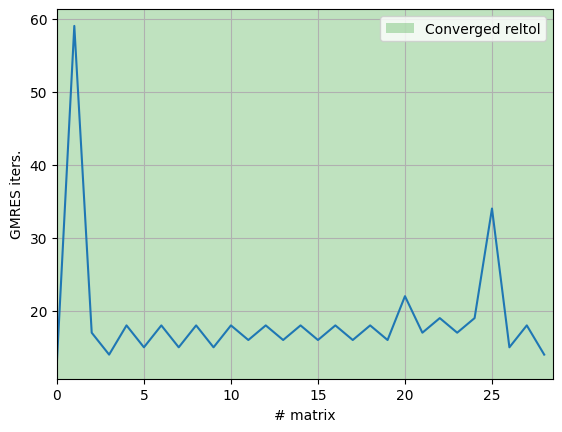

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

18

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 14
sliding = 0
open = 0
transition = 14
total = 14


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.08


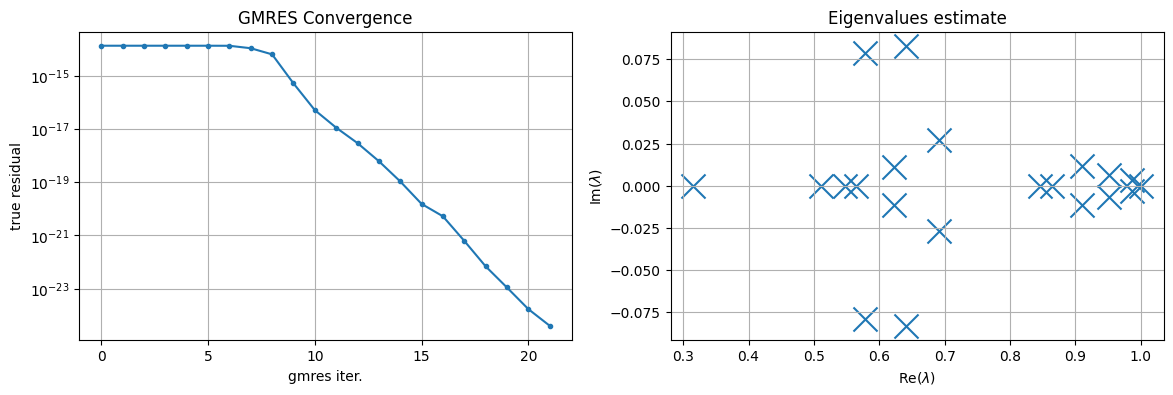

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

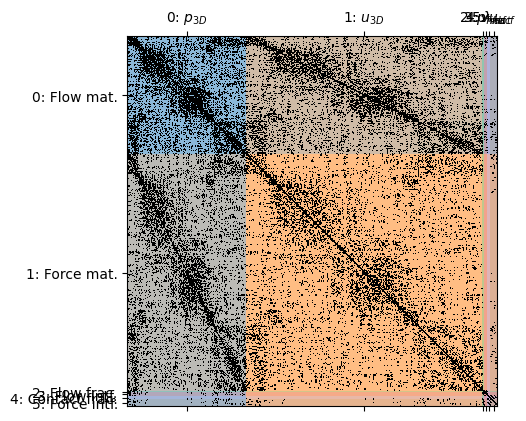

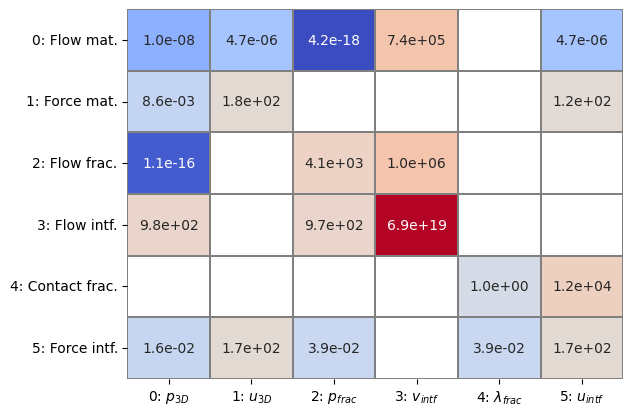

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

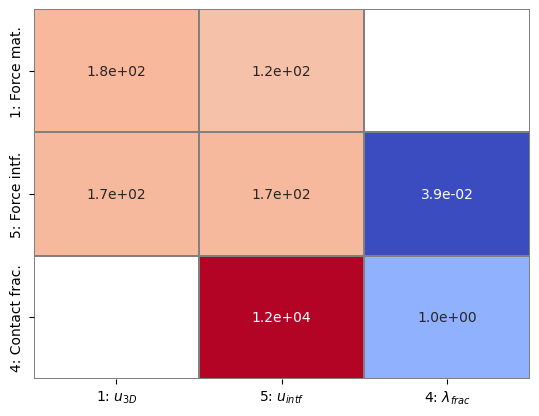

In [9]:
J[[1,5,4]].plot_max()

Solve  took: 0.02


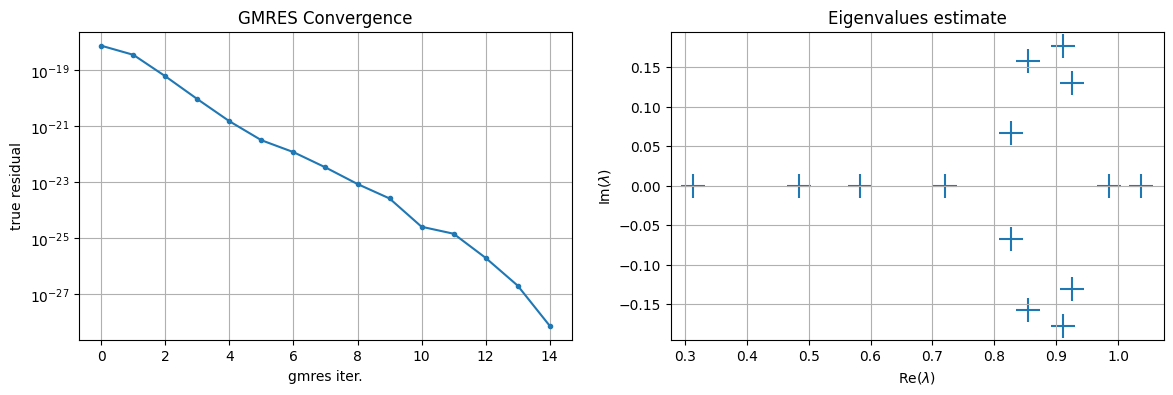

In [10]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

It's very bad to solve 1 and 5 separately. So it's either to solve:
* `J[4]` and `S[1, 5]`
* `J[1, 5]` and `S[4]`

It turns out that it does not matter - with or without tangential sliding

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Solve  took: 0.02


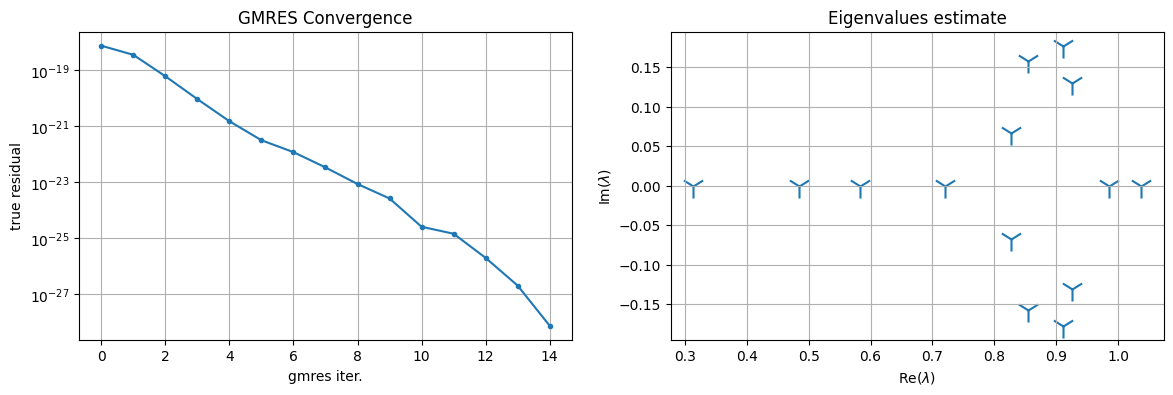

In [11]:
def make_J44_inv_no_sliding_tangential(model, bmat, idx_zeros):
    stab = -bmat[4, 5].mat @ inv_block_diag(bmat[5, 5].mat, nd=model.nd) @ bmat[5, 4].mat
    zeros_2d = np.zeros(len(idx_zeros) * 2, dtype=bool)
    zeros_2d[np.array(idx_zeros, dtype=int) * 2 + 1] = True
    stab[zeros_2d] = 0

    S44 = J[4, 4].mat + stab
    return inv_block_diag(S44, nd=model.nd)


transition = get_transition(data, idx=mat_idx)
sliding = get_sliding(data, idx=mat_idx)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_no_sliding_tangential(
        model=model, bmat=J, idx_zeros=(sliding)
    ),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))

Solve  took: 0.25
PETSc Converged Reason: -5
lambda min: 0.36011478705926575


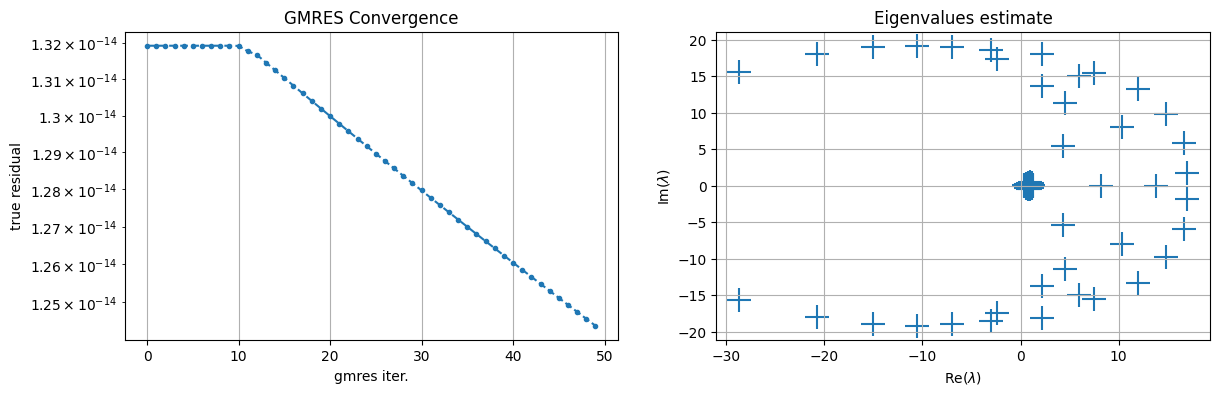

In [16]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv, make_J44_inv_bdiag


schema = SolveSchema(
    groups=[3],
    # solve=lambda bmat: extract_diag_inv(bmat.mat),
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))